In [33]:
import torch
import cv2
import numpy as np
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import models
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pickle import load
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [34]:
food_df = pd.read_csv('food_df.csv')

In [35]:
test_df = pd.read_csv('test_df.csv')

In [36]:
test_df

,labels,path,sample_nrs,img_types,sample_names,sample_names_nrs,weight
0,apple,data/ECUSTFD/JPEGImages/apple007S(1).JPG,7,S,apple,apple007,325.0
1,apple,data/ECUSTFD/JPEGImages/apple017T(23).JPG,17,T,apple,apple017,255.0
2,apple,data/ECUSTFD/JPEGImages/apple013S(4).JPG,13,S,apple,apple013,252.5
3,apple,data/ECUSTFD/JPEGImages/apple017T(21).JPG,17,T,apple,apple017,255.0
4,apple,data/ECUSTFD/JPEGImages/apple002T(1).JPG,2,T,apple,apple002,232.5
...,...,...,...,...,...,...,...
282,tomato,data/ECUSTFD/JPEGImages/tomato002T(6).JPG,2,T,tomato,tomato002,154.2
283,tomato,data/ECUSTFD/JPEGImages/tomato004S(2).JPG,4,S,tomato,tomato004,173.4
284,tomato,data/ECUSTFD/JPEGImages/tomato003T(34).JPG,3,T,tomato,tomato003,186.4
285,tomato,data/ECUSTFD/JPEGImages/tomato004S(18).JPG,4,S,tomato,tomato004,173.4


In [37]:
def random_inference(random_sample):
    food_labels = ['apple', 'banana', 'bread', 'bun', 'doughnut', 'egg',
                   'fired_dough_twist', 'grape', 'lemon', 'litchi', 'mango', 'mooncake',
                   'orange', 'peach', 'pear', 'plum', 'qiwi', 'sachima', 'tomato']
    
    
    og_img = cv2.imread(random_sample['path'].tolist()[0])
    img_torgb = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_torgb, (128,128))
    img = np.array(img_resized)
    img_expanded = np.expand_dims(img, axis=0)
    
    food_classifier = models.load_model('checkpoints/cl/best_model.h5')
    y_pred_cl = food_classifier.predict(img_expanded)
    y_pred_cl = np.argmax(y_pred_cl,axis=1)
    y_pred_cl = food_labels[y_pred_cl[0]]
    y_true_cl = random_sample['labels'].tolist()[0]
    
    model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5_food_models/50 epochs/best.pt')
    results = model(img,)
    if(len(results.xyxy[0])>=2):
        if(results.xyxy[0][0][-1]!=19):
            obj =  results.xyxy[0][0][0:4].tolist()
            obj = [int(i) for i in obj]
        elif(results.xyxy[0][1][-1]!=19):
            obj =  results.xyxy[0][1][0:4].tolist()
            obj = [int(i) for i in obj]
        mask = np.zeros(img.shape,np.uint8)
        mask[obj[1]:obj[3],obj[0]:obj[2]] = img[obj[1]:obj[3],obj[0]:obj[2]]
    
    food_regressor = models.load_model('checkpoints/re/best_model.h5')
    scaler = load(open('scaler.pkl', 'rb'))
    mask_resized = cv2.resize(mask, (128,128))
    mask_expanded = np.expand_dims(mask_resized, axis=0)
    y_true_re = random_sample['weight'].tolist()[0]
    y_pred_re = food_regressor.predict(mask_expanded)
    y_pred_re = scaler.inverse_transform(y_pred_re)[0][0]
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
    ax1.imshow(img_resized)
    ax1.set_title(f'Actual Food: {y_true_cl} \n Food Prediction: {y_pred_cl}')
    ax2.imshow(mask_resized)
    ax2.set_title(f'Actual Weight (gr): {y_true_re} \n Weight prediction (gr): {y_pred_re:.1f}')
    plt.show()
    return y_pred_re

Using cache found in /Users/stergios/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7105153 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2021-6-19 torch 1.9.0 CPU



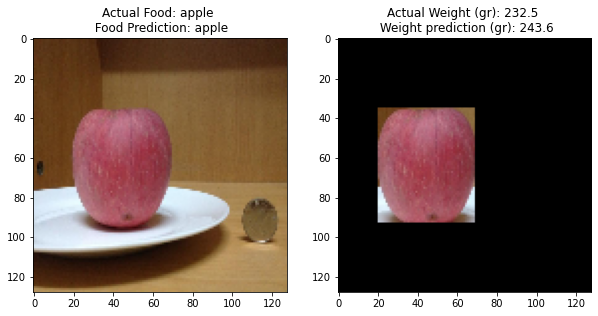

In [38]:
%matplotlib inline
try:
    random_sample = test_df.sample(n=1)
    y_pred_re_1 = random_inference(random_sample)
except:
    print('Error')


Using cache found in /Users/stergios/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7105153 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2021-6-19 torch 1.9.0 CPU



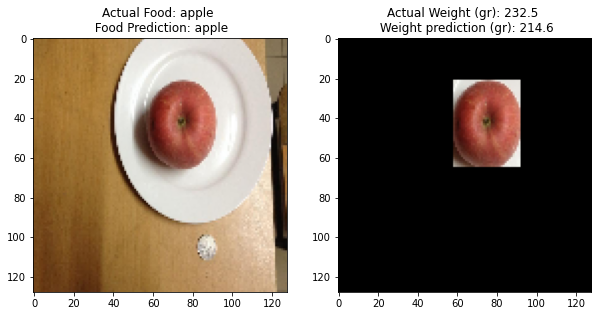

In [39]:
%matplotlib inline
if(random_sample['img_types'].tolist()[0]=='S'):
    img_type = 'T'
else: img_type = 'S'
try:
    rnd_dif_type = food_df[(food_df['sample_names_nrs']==random_sample['sample_names_nrs'].tolist()[0]) & (food_df['img_types']==img_type)].sample(n=1)
    y_pred_re_2 = random_inference(rnd_dif_type)
except:
    print('Error')

In [40]:
y_pred_total = (y_pred_re_1 + y_pred_re_2) / 2
y_true_re = random_sample['weight'].tolist()[0]
print(f'Actual Weight (gr): {y_true_re:.1f}')
print(f'Average Weight Prediction (gr): {y_pred_total:.1f}')

Actual Weight (gr): 232.5
Average Weight Prediction (gr): 229.1
